# Imports and Setup

In [ ]:
import json
import os
import re
import copy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from uuid import uuid4

In [ ]:
# Set output directory
OUTPUT_DIR = "./dataset_analysis"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Consolidation Maps + Normalization Functions

In [ ]:
# Consolidation maps
CONSOLIDATION_MAPS = {
    # Tenant Representative Details
    "First Name": {
        "unknown": [""]
    },
    "Last Name": {
        "unknown": [""]
    },
    "Email": {
        "unknown": [""]
    },
    "Phone": {
        "unknown": [""]
    },
    # Company Details
    "Company Name": {},
    "Industry": {
        "healthcare": ["healthcare", "healthcare/nonprofit"],
        "nonprofit": ["nonprofit", "healthcare/nonprofit", "nonprofit/creative"],
        "legal": ["legal"],
        "creative": ["nonprofit/creative", "retail", "creative (media/design)", "creative/design", "manufacturing/plastics", "creative/arts"],
        "tech": ["tech"],
        "finance": ["finance"],
        "unknown": [""]
      },
    "Company Size": {
        "micro (5-20 employees)": ["micro (5-20 employees)", "micro (5–20 employees)", "micro 5-20 employees", "micro (5-20)"],
        "small (20-75 employees)": ["small (20-75 employees)", "small (20–75 employees)", "small 20-75 employees", "small (20-75)"],
        "medium (75-250 employees)": ["medium (75-250 employees)", "medium (75–250 employees)", "medium 75-250 employees", "medium (75-250)"],
        "large (250-1000 employees)": ["large (250-1000 employees)", "large (250–1000 employees)", "large (250-1,000 employees)", "large 250-1000 employees", "large (250-1)", "000 employees)", "large (250–1,000 employees)"],
        "unknown": [""]
      },
    "Growth Stage": {
        "early-stage": ["pre-seed", "startup", "start-up"],
        "scaling": ["growth", "growing", "scaling", "expansion", "expanding"],
        "mature": ["mature", "stable", "steady"],
        "unknown": [""]
      },
    "Current Neighborhood": {
        "downtown": ["west village", "east village", "financial district", "tribeca", "soho", "downtown manhattan", "downtown", "brooklyn", "williamsburg", "dumbo", "brooklyn (williamsburg", "dumbo)", "east village or chelsea", "finance district"],
        "midtown east": ["midtown east", "grand central", "near grand central"],
        "midtown west": ["chelsea", "hudson yards", "midtown west", "hell's kitchen", "23rd to 28th street", "23rd to 28th streets", "flatiron", "riverside area", "high line", "chelsea or midtown", "harlem"]
    },
    # Top-level tenant_profile fields
    "First Interaction": {
        "unknown": [""]
    },
    "Last Interaction": {
        "unknown": [""]
    },
    "Decision-Maker Role": {
        "executive": ["executive director", "coo", "cfo", "decision maker", "head of expansion", "director"],
        "ceo": ["ceo", "ceo & founder"],
        "partner": ["partner", "managing partner", "senior partner", "partner and firm managing director", "partner & office manager", "partner & lead attorney", "partner & lead counsel", "partner/managing attorney", "partner/lead attorney"],
        "facilities": ["facilities director", "facilities manager", "facility manager", "facilities coordinator", "director of facilities"],
        "founder": ["founder", "founder & facilities lead", "founder and cfo"],
        "operations": ["director of operations", "operations director", "head of operations", "operations manager", "operations lead", "facilities & operations director", "head of logistics", "program director", "external consultant"],
        "unknown": ["", "none"]
    },
    "Moving Timeline": {
        "swift (0–2 months)": ["immediate (within 30 days)", "immediate (30 days)", "immediate (within 1 month)", "short-term (within 1 month)", "short-term (within 30 days)", "short-term (within 45 days)", "short-term (within 60 days)", "short-term (within 2 months)", "short-term (1-2 months)", "short-term (2 months)", "within 60 days", "short-term (mid-november)", "short-term (within 60 days, ideally by mid-jan)"],
        "prompt (2–6 months)": ["short-term (3-6 months)", "short-term", "short-term (3 months)", "short-term (4-6 months)", "short-term (within 3 months)", "short-term (3-4 months)", "short-term (2-3 months)", "short-term (1-3 months)", "short-term (within 4 months)", "short-term (within 6 months)", "short-term (less than 3 months)", "short-term (less than 6 months)", "short-term (next quarter)", "short-term (within 6 weeks)", "short-term (within 8 weeks)", "3-4 months", "4-6 months", "short-term (end of february)", "medium (3-6 months)", "medium-term (3-6 months)", "flexible (within 6 months)", "short-term (60 days, ideally by mid-jan)", "short-term (by end of dec)", "3–4 months", "short-term (3–4 months)", "short-term (3–6 months)", "short-term (1–3 months)", "medium (3–6 months)", "short-term (4–6 months)"],
        "steady (6–12 months)": ["short-term (6 months)", "short-term (before q2 2026)", "long-term (6-9 months)", "short-term (6-9 months)", "short-term (within 9 months)", "moderate (8-12 months)", "nearing lease expiry (9 months)", "9-12 months (q2 move-in target)", "early january", "mid-january (short-term)", "early next year", "mid-december", "short-term (before jan 15, 2026)", "short-term (6–9 months)"],
        "horizon (12+ months)": ["long-term (9-18 months)", "exploratory (no fixed timeline)", "moderate urgency (lease expiring march 2026)", "hesitant"],
        "unknown": [""]
    },
    "Pain Points": {
        "Lease Expiration & Urgency": ["Lease ending soon", "Expiring lease end of month", "Urgent transition due to lease expiry", "Lease expiration urgency", "Lease expiration in 30 days", "Current lease ending early next year", "Upcoming lease expiry", "Tight lease expiry", "End of current lease"],
        "Budget Constraints": ["Limited budget", "Tight budget constraints", "Cost sensitivity", "High operational costs", "Budget constraints due to recent rent hike", "Limited options in target budget"],
        "Limited Space for Growth": ["Current space too cramped", "Too cramped current space", "Limited current space", "Current space too small", "Small current space", "Limited room to expand", "Outgrowing current location", "Current space lacks scalability", "Limited current space hampers growth", "Upcoming growth needs"],
        "Inflexible Lease Terms": ["Limited flexibility in lease terms", "Rigid lease options", "Need flexible lease", "Need adaptable lease terms", "Lease flexibility", "Inflexible lease terms"],
        "Poor HVAC & Ventilation": ["HVAC issues", "Outdated HVAC", "Unreliable HVAC in current space", "Outdated ventilation", "Poor accessibility", "Inadequate ventilation in current space", "Outdated HVAC system", "Inadequate HVAC capacity"],
        "Limited Natural Light": ["Limited natural light", "Lack of natural light", "Limited natural light in current space"],
        "Parking Accessibility": ["Limited parking", "Limited nearby parking", "Parking availability", "Parking access", "Parking challenges", "Parking difficulty", "Limited parking options", "Limited parking near current office", "Limited parking options in Harlem"],
        "Transit & Location Access": ["Transit access for staff", "Limited transit options in current office", "Current space too distant from hospitals", "Current space lacks foot traffic", "Need accessible location", "Location accessibility", "Need proximity to Mount Sinai", "Need for accessible location for patients"],
        "Need for Visibility / Foot Traffic": ["Need high visibility", "Limited visibility in current location", "Need for foot traffic", "Limited retail presence in Chelsea", "Need for visibility in busy neighborhood", "Limited visibility at current location", "Desire for high foot traffic", "Need high visibility to attract customers", "Limited flagship retail presence in Manhattan"],
        "Privacy & Confidentiality Needs": ["Need privacy for confidential work", "Need confidentiality for legal work", "Need secure, private environment", "Limited private rooms", "Lack of sound privacy in current space", "Need for soundproofing and security"],
        "Security Concerns": ["Need better security", "Desire for better security", "Need secure facilities", "Current space lacks sufficient security", "Proximity to busy areas causing security concerns", "Need confidentiality and security"],
        "Outdated Infrastructure": ["Outdated facilities", "Outdated infrastructure", "Older building infrastructure", "Need to upgrade facilities", "Current space outdated"],
        "ADA & Accessibility Compliance": ["Accessibility concerns", "Accessibility requirements", "Accessibility for elderly patients", "Need ADA compliance", "Need ADA features", "Need accessible, compliant space", "Limited accessibility", "Limited accessibility in current space", "Need compliance and accessibility"],
        "Build-out Costs & Renovation Timelines": ["Build-out costs", "Build-out delays concern", "Reluctance for lengthy renovations", "Funding confirmation delays", "Funding uncertainty", "Build-out timeline"],
        "Board & Internal Approval Delays": ["Board approval delays", "Board approval required", "Board cautious about quick move", "Justifying costs to board", "Limited internal approvals"],
        "Aesthetic & Modern Workspace Desires": ["Lack of aesthetic appeal in current office", "Desire for a professional image", "Need for a modern workspace", "Current space too conventional", "Need modern amenities", "Need high-end finishes"],
        "Need for Quick Move-In": ["Need quick move-in", "Quick move required", "Tight move-in schedule", "Flexible move-in date", "Need for quick move"],
        "Lack of Specialized Facilities": ["Need for specialized healthcare setup", "Limited lab facilities", "Need compliant healthcare space", "Limited current space for community events", "Need for community outreach space", "Need space suitable for community programs"],
        "Legal & Medical Proximity Needs": ["Need proximity to courts and clients", "Need proximity to legal institutions", "Need accessible space close to hospitals"],
        "Noise & Disruption Issues": ["Noise concern", "Disruptions in current space", "High noise levels in current location", "Noisy neighbors", "Noisy neighbors in current space"],
        "Flexible Layout Needs": ["Need flexible layout", "Need for customizable layout", "Flexible space for expanding team", "Flexible lease terms due to project delays", "Need versatile space for collaborative projects", "Limited collaboration space"],
        "Community & Public Engagement Requirements": ["Finding welcoming, community-oriented space", "Visibility for community outreach", "Need for community outreach space", "Community engagement venue"],
        "Need for Creative or Inspiring Environment": ["Need creative environment", "Need for inspiring environment", "Limited flexible creative spaces in East Village", "Limited creative space options in Tribeca", "Need flexible environment for gallery and workshop"],
        "Limited Availability in Target Areas": ["Limited affordable retail options", "Limited retail locations in prime neighborhoods", "Limited space in current Midtown location", "Limited current retail footprint in Harlem"],
        "Sustainability / Eco-Friendly Requirements": ["Desire for sustainability features", "Eco-friendly workspace importance", "Limited eco-friendly options in retail spaces", "Need eco-friendly features"],
        "Need for High-End Amenities": ["Need for high-end amenities", "Need modern infrastructure"],
        "Unreliable Internet / Tech Infrastructure": ["Need for fast internet infrastructure", "Need tech-ready space", "Need better security and internet", "Unreliable infrastructure in current space"],
        "Desire for Historic / Cultural Character": ["Desire for a historic ambiance", "Lack of suitable cultural spaces in Manhattan", "Lack of character in current location"],
        "Unknown": [""]
      },
    "Urgency Score": {
        "unknown": [""]
    },
    "Outcome": {
        "tour scheduled": ["tour scheduled", "scheduled tour", "scheduled property tour", "scheduling a tour with landlord negotiation in progress", "interest expressed, tour scheduled", "scheduled tour with potential for quick lease signing", "virtual tour scheduled, negotiation ongoing", "tour scheduled for tuesday", "scheduling tour, potential proceeding", "tour scheduled and negotiating rent concession", "tour scheduled, negotiating lease term", "tour scheduled for thursday", "scheduled tour for monday", "viewing scheduled, waiting for board approval", "space viewed, awaiting approval", "in-person tour scheduled", "ongoing review, potential tour scheduled", "board approval pending; tour scheduled", "interest confirmed, tour scheduled", "pending scheduling of tour and further discussions", "scheduled tour, negotiating rent and incentives", "negotiated rent, tour scheduled", "scheduled tour; negotiations on rent", "ongoing review, tour scheduled", "tour scheduled, internal review pending", "tour booked, negotiations pending", "tour scheduled, negotiations potentially ongoing", "scheduled tour of park avenue space", "tour scheduled, negotiating lease terms", "pending board approval, viewing scheduled", "scheduled tour with flexible lease terms discussed", "space tour completed, interest expressed", "tour scheduled and positive interest", "tour scheduled, potential for negotiation", "tour scheduled, considering options", "tour scheduled, incentives discussed", "scheduling tour, considering ti allowances", "in-person property viewing scheduled", "ongoing viewing arrangements", "scheduled tour and lease review", "initial tour scheduled", "tour scheduled and potential negotiation", "tour scheduled and negotiations ongoing", "tour scheduled, negotiation ongoing", "tour scheduled for thursday at 10am", "tour scheduled for tomorrow at 11am", "tour scheduled, reviewing options"],
        "negotiations ongoing": ["negotiation ongoing", "ongoing negotiations", "negotiations ongoing", "pending negotiation on rent", "ongoing negotiations, awaiting landlord flexibility on rent", "interested in touring, negotiations pending", "lease negotiation in progress", "negotiations ongoing, waiting for landlord response", "interest confirmed, negotiations ongoing", "ongoing negotiations with price adjustment potential", "ongoing negotiations, awaiting internal approval", "interest in viewing space, negotiation ongoing", "negotiations ongoing, offer pending", "lease pending approval, negotiations ongoing", "initial tour completed, negotiations ongoing", "negotiations ongoing, proposal sent", "negotiations ongoing, considering chelsea space but seeking rent concessions", "ongoing negotiations, potential lease agreement", "viewings scheduled and negotiation ongoing", "negotiation pending", "negotiations ongoing, tour completed"],
        "pending approval": ["awaiting approval", "pending decision, board review ongoing", "pending board approval, negotiating rent", "pending board approval", "pending approval, follow-up needed", "pending final review, awaiting decision", "interested in touring, pending board approval", "interest confirmed, board approval pending", "interested, pending approvals", "awaiting internal approval"],
        "lease pending": ["lease agreement pending", "lease likely, pending formal agreement"],
        "lease signed": ["lease agreement signed", "lease signed and approval secured"],
        "interested": ["interested in viewing space", "interest confirmed", "ongoing review", "considering options", "on hold", "ongoing search", "review in progress", "interested, space on hold", "ongoing search, options being vetted"],
        "unknown": [""]
    },
    "Tenant Personality": {
        "decisive": ["decisive"],
        "enthusiastic": ["enthusiastic"],
        "hesitant": ["hesitant", "detail-obsessed", "skeptical"],
        "unknown": [""]
    },
    "Property Type": {
        "office": ["office", "office with labs", "open-plan office", "office open-plan", "office private zones", "office co-working", "office clinic", "office (open-plan", "private zones)", "flexible office / co-working", "office (open-plan, private zones)", "creative (loft)", "creative open space", "studio/loft", "creative (loft/open space)", ""],
        "medical": ["office (medical)", "office (medical/clinic)", "office (medical/healthcare use)", "office (outpatient clinics)", "office/clinic", "medical office", "medical suite", "outpatient clinic", "medical outpatient clinic", "healthcare", "clinic"],
        "retail": ["retail", "retail/community space"],
        "flex-space": ["flex-space", "flex-space/retail", "flex-space mixed-use", "flex-space creative", "flex-space warehouse", "flex-space open-plan", "flex-space (mixed-use adaptability)", "flex-space (retail/creative)", "flex-space (mixed-use", "open-plan)", "flex-space / warehouse", "flex-space (mixed-use, open-plan)"],
        "event venue": ["event venue"],
        "unknown": [""]
    },
    "Preferred Neighborhood": {
        "midtown west": ["hell’s kitchen", "chelsea", "hudson yards", "midtown west", "23rd to 28th street", "23rd to 28th streets", "flatiron", "riverside area", "high line", "chelsea or midtown", "harlem", "hell's kitchen"],
        "downtown": ["west village", "east village", "financial district", "tribeca", "soho", "downtown manhattan", "downtown", "brooklyn", "williamsburg", "dumbo", "brooklyn (williamsburg", "dumbo)", "east village or chelsea", "finance district"],
        "midtown east": ["midtown east", "grand central", "near grand central", "midtown"],
        "unknown": [""]
    },
    "Estimated or Stated Budget": {
        "$40k-$50k": ["$45k/month", "$40k/month", "$55k/month", "$45k–$50k/month", "$40k/month, flexible", "$45k–$55k/month", "$40k–$45k/month", "$35k–$36k/month", "$43k/month", "$42k/month", "$40k–$55k/month", "$35k/month, flexible"],
        "$60k-$70k": ["$60k/month", "$65k/month", "$60k–$65k/month", "$65k/month, negotiable", "$60k–$70k/month", "$60k/month, flexible", "$60k, flexible to $65k", "$60/sqft", "$60k/month, flexible"],
        "$30k-$40k": ["$35k/month", "$36k/month", "$30k/month", "$65k–$70k/month", "$38k–$42k/month", "$30k–$35k/month", "$36k/month", "$27k–$30k/month", "$28k/month", "$35k/month, flexible"],
        "$70k+": ["$70k/month", "$75k/month", "$70k", "$70/sf", "$70k–$80k/month"],
        "$50k-$60k": ["$55k/month", "$50k/month", "$50/sqft", "55"],
        "$0k-$30k": ["$20k/month", "$25k/month", "$30k–$35k/month", "$27k–$30k/month", "$28k/month"],
        "unknown": ["$60 per sqft", "$50/sqft", "$65/psf", "$70/sf"]
    },
    "Must-Haves": {
        "natural light": ["good natural light", "large windows", "plenty of windows"],
        "public transit access": ["accessible transit", "proximity to public transit", "transit access", "good transit access", "accessible public transit", "good subway access"],
        "accessibility": ["accessible location", "accessible for visitors", "accessible for patients", "accessible building", "accessible entrances", "accessible entry", "ground-floor accessibility", "easily accessible for patients and staff", "easy access", "good accessibility"],
        "ada compliance": ["ada-compliant", "ada accessible", "wheelchair accessible", "wheelchair accessible bathrooms", "accessible restrooms"],
        "ventilation": ["good ventilation", "excellent ventilation", "proper ventilation"],
        "hvac": ["modern hvac", "reliable hvac", "high-end hvac", "energy-efficient hvac", "upgraded hvac", "dedicated hvac", "medical-grade hvac", "hospital-grade hvac"],
        "open-plan layout": ["open layout", "open floor plan", "open-plan"],
        "flexible layout": ["flexible layout", "flexible open space", "flexible configuration", "adaptable layout", "expandable layout", "modifiability"],
        "conference rooms": ["dedicated conference room", "private conference rooms", "conference area", "conference facilities", "meeting rooms", "private meeting rooms", "small meeting area", "shared conference rooms"],
        "reliable internet": ["high-speed internet", "reliable internet", "fiber internet", "high-speed secure internet"],
        "security features": ["secure access", "secure entry", "high-security access", "security system", "on-site security", "good security features", "high-security features"],
        "parking": ["parking options", "ample parking", "parking nearby", "parking access"],
        "street visibility": ["street-level visibility", "good street visibility", "street visibility", "high visibility"],
        "street access": ["street-level access", "street access", "ground-floor access", "ground floor"],
        "foot traffic": ["high foot traffic"],
        "private spaces": ["private offices", "private suites", "private exam rooms", "private consultation rooms", "private zones", "private labs"],
        "outdoor space": ["outdoor terrace", "outdoor access"],
        "soundproofing": ["good acoustics", "soundproof conference rooms"],
        "flexible lease": ["flexible lease terms", "flexible lease"],
        "leed-certified": ["green certifications (leed)", "leed certification"],
        "proximity to healthcare": ["proximity to hospitals", "close to hospitals", "proximity to healthcare facilities"],
        "proximity to courthouses": ["near courts", "close to courthouses"],
        "unknown": [""]
    },
    "Nice-to-Haves": {
        "parking": ["nearby parking", "parking nearby", "onsite parking", "parking near building", "visitor parking nearby", "parking garage nearby", "parking options"],
        "outdoor space": ["outdoor terrace", "rooftop terrace", "terrace access", "private courtyard", "outdoor access", "outdoor seating"],
        "natural light": ["ample natural light", "large windows"],
        "open-plan layout": ["open-plan layout", "open floor plan", "open plan"],
        "flexible layout": ["flexible layout", "flexible layouts"],
        "conference areas": ["shared conference room", "private conference rooms", "onsite conference rooms", "small conference room", "conference areas", "conference area"],
        "breakout areas": ["breakout areas", "breakout rooms", "breakout spaces"],
        "signage": ["outdoor signage", "signage permissions", "signage flexibility", "signage opportunities", "outdoor signage area", "prominent signage options"],
        "building amenities": ["onsite gym", "fitness center", "fitness amenities", "fitness facilities", "building amenities (gym, café)", "onsite amenities", "lounge amenities"],
        "leed certification": ["leed-certified building", "leed certification", "green certifications", "eco-friendly features", "energy-efficient systems"],
        "accessibility": ["accessible entrance", "ground-floor access", "accessible location", "accessibility features", "ground floor"],
        "public transit access": ["proximity to public transit", "nearby public transit", "proximity to subway", "transit access", "proximity to public transport"],
        "exposed brick": ["exposed brick", "original brick walls", "industrial aesthetic"],
        "hvac upgrades": ["recent hvac upgrades"],
        "high ceilings": ["high ceilings"],
        "quiet environment": ["quiet environment", "quiet building"],
        "on-site maintenance": ["on-site maintenance"],
        "corner unit": ["corner office", "corner unit", "corner visibility"],
        "unknown": [""]
    },
    "Space Size": {
        "0-999 sf": ["950 sqft"],
        "1000-2499 sf": ["1,500 sqft", "1,300 sqft", "1,200 sqft", "1,900 sqft", "2,000 sqft", "2,100 sqft", "2,500 sqft"],
        "2500-4999 sf": ["3,000 sqft", "3,200 sqft", "3,500 sqft", "3,000-3,500 sqft", "3,500 sqft", "3,800 sqft", "3,500 sqft (future expansion possible)", "3,500–4,200 sqft", "3,000-4,000 sqft", "3,000–3,500 sqft"],
        "5000-7499 sf": ["4,000 sqft", "4,200 sqft", "4,500 sqft", "4,800 sqft", "4,000–5,000 sqft", "4,000–4,500 sqft", "4,000-5,000 sqft", "approx. 4,000 sqft"],
        "7500-9999 sf": ["8,000 sqft", "8,200 sqft", "9,500 sqft", "8,000–10,000 sqft", "7,500 sqft", "8,500 sqft", "8,000 sq ft", "9,000 sqft"],
        "10000+ sf": ["10,000 sqft", "12,000 sqft", "20,000 sqft", "11,500 sqft", "11,000 sqft", "15,000 sqft", "14,000 sqft"]
    },
    "Preferred Lease Term": {
        "<1 year": ["short-term", "flexible, short-term possible", "short-term possible", "6 month to 1 year (short to medium-term)", "6 months to 1 year (short to medium-term)", "6-12 months", "12 months", "1 year", "1 yr", "1 year with renewal"],
        "flexible": ["flexible", "flexible (long-term preferred)", "flexible (1–3 years)", "flexible (1-3 years)", "flexible (1-2 years)", "flexible (1-2 yrs)", "flexible (1-2 year)", "flexible (3-5 years)", "flexible (3-5 yrs)", "flexible (3-5 year)", "flexible, 3–5 years"],
        ">7 year": ["long-term (8-15 years)", "long-term (8-15 year)", "at least 7 years", "5+ years", "10 years", "10 yrs", "10 year"],
        "2 year": ["2 years", "2 yrs", "2 year", "2 years with renewal", "2 yrs with renewal", "2 year with renewal", "2 years with extension option", "2 yrs with extension option", "2 year with extension option", "1-2 years with extension", "1-2 yrs with extension", "1-2 year with extension", "2-3 years", "2-3 yrs", "2-3 year", "2-4 years", "2-4 yrs", "2-4 year"],
        "3 year": ["3 years", "3 yrs", "3 year", "3 years with renewal", "3 yrs with renewal", "3 year with renewal", "3 years with renewal options", "3-4 years", "3-4 yrs", "3-4 year", "3-5 years", "3-5 yrs", "3-5 year", "3–5 years", "3 or 5 years", "3 or 5 yrs", "3 or 5 year", "up to 5 years", "up to 5 yrs", "up to 5 year", "3-10 years", "3-10 yrs", "3-10 year"],
        "5 year": ["5 years", "5 yrs", "5 year", "5 years with renewal", "5 yrs with renewal", "5 year with renewal", "5 years with renewal options", "5-7 years", "5-7 yrs", "5-7 year", "4-5 years", "4-5 yrs", "4-5 year", "4-6 years", "4-6 yrs", "4-6 year"],
        "7 year": ["7 years", "7 yrs", "7 year"]
      }
}

In [ ]:
# Feature configurations
FEATURES = {
    "First Name": {"nested_path": ["tenant_profile", "Tenant Representative Details", "First Name"]},
    "Last Name": {"nested_path": ["tenant_profile", "Tenant Representative Details", "Last Name"]},
    "Email": {"nested_path": ["tenant_profile", "Tenant Representative Details", "Email"]},
    "Phone": {"nested_path": ["tenant_profile", "Tenant Representative Details", "Phone"]},
    "Company Name": {"nested_path": ["tenant_profile", "Company Details", "Company Name"]},
    "Industry": {"nested_path": ["tenant_profile", "Company Details", "Industry"], "multi_label": True},
    "Company Size": {"nested_path": ["tenant_profile", "Company Details", "Company Size"]},
    "Growth Stage": {"nested_path": ["tenant_profile", "Company Details", "Growth Stage"]},
    "Current Neighborhood": {"nested_path": ["tenant_profile", "Company Details", "Current Neighborhood"]},
    "First Interaction": {"nested_path": ["tenant_profile", "First Interaction"]},
    "Last Interaction": {"nested_path": ["tenant_profile", "Last Interaction"]},
    "Decision-Maker Role": {"nested_path": ["tenant_profile", "Decision-Maker Role"]},
    "Moving Timeline": {"nested_path": ["tenant_profile", "Moving Timeline"]},
    "Pain Points": {"nested_path": ["tenant_profile", "Pain Points"], "multi_label": True},
    "Urgency Score": {"nested_path": ["tenant_profile", "Urgency Score"]},
    "Outcome": {"nested_path": ["tenant_profile", "Outcome"]},
    "Tenant Personality": {"nested_path": ["tenant_profile", "Tenant Personality"]},
    "Property Type": {"nested_path": ["tenant_profile", "Property Preferences", "Property Type"]},
    "Preferred Neighborhood": {"nested_path": ["tenant_profile", "Property Preferences", "Preferred Neighborhood"], "multi_label": True},
    "Estimated or Stated Budget": {"nested_path": ["tenant_profile", "Property Preferences", "Estimated or Stated Budget"]},
    "Must-Haves": {"nested_path": ["tenant_profile", "Property Preferences", "Must-Haves"], "multi_label": True},
    "Nice-to-Haves": {"nested_path": ["tenant_profile", "Property Preferences", "Nice-to-Haves"], "multi_label": True},
    "Space Size": {"nested_path": ["tenant_profile", "Property Preferences", "Space Size"]},
    "Preferred Lease Term": {"nested_path": ["tenant_profile", "Property Preferences", "Preferred Lease Term"]}
}

# Functions

In [ ]:
def extract_feature(data, nested_path, multi_label=False):
    """Extract a feature from nested JSON data."""
    try:
        value = data
        for key in nested_path:
            value = value[key]
        if multi_label:
            if isinstance(value, str):
                return [item.strip().lower() for item in value.split(",") if item.strip()]
            elif isinstance(value, list):
                return [str(item).strip().lower() for item in value if str(item).strip()]
            return []
        return str(value).strip().lower() if value is not None else ""
    except (KeyError, TypeError) as e:
        print(f"Warning: Field {nested_path} not found in data: {str(e)}")
        return [] if multi_label else ""

In [ ]:
def apply_consolidation(values, consolidation_map, multi_label=False):
    """Apply consolidation map to a list of values."""
    if multi_label:
        consolidated = []
        for value_list in values:
            consolidated_list = []
            for value in value_list:
                # Find the key that the value belongs to
                found = False
                for category, value_list in consolidation_map.items():
                    if value in value_list:
                        consolidated_list.append(category)
                        found = True
                        break
                if not found:
                    consolidated_list.append(value)  # If not found, keep original value
            consolidated.append(list(set(consolidated_list)))  # Remove duplicates within a record
        return consolidated
    else:
        # Apply consolidation for non-multi-label
        consolidated = []
        for value in values:
            found = False
            for category, value_list in consolidation_map.items():
                if value in value_list:
                    consolidated.append(category)
                    found = True
                    break
            if not found:
                consolidated.append(value)  # If not found, keep original value
        return consolidated


In [ ]:
def visualize_distribution(raw_counts, consolidated_counts, feature, output_dir, multi_label=False):
    """Visualize raw and consolidated distributions for a feature."""
    # Plot even if only one value or missing values, unless counts are completely empty
    if not raw_counts:
        print(f"Warning: No data for {feature}, creating empty plot")
        raw_counts = {"No Data": 0}
        consolidated_counts = {"No Data": 0}

    plt.figure(figsize=(12, 6))

    # Raw distribution
    plt.subplot(1, 2, 1)
    raw_series = pd.Series(raw_counts).sort_values(ascending=False).head(20)
    raw_series.plot(kind='bar')
    plt.title(f"{feature} (Raw)")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')

    # Consolidated distribution
    plt.subplot(1, 2, 2)
    consolidated_series = pd.Series(consolidated_counts).sort_values(ascending=False).head(20)
    consolidated_series.plot(kind='bar')
    plt.title(f"{feature} (Consolidated)")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    output_path = os.path.join(output_dir, f"{feature.lower().replace(' ', '_')}_distribution.png")
    plt.savefig(output_path)
    print(f"Saved plot for {feature} at {output_path}")
    plt.show()
    plt.close()

In [ ]:
def analyze_and_visualize(data, output_dir):
    """Analyze and visualize distributions for all features."""
    os.makedirs(output_dir, exist_ok=True)

    for feature, config in FEATURES.items():
        print(f"Analyzing and visualizing {feature}...")
        nested_path = config["nested_path"]
        multi_label = config.get("multi_label", False)

        # Extract raw values
        raw_values = [extract_feature(item, nested_path, multi_label) for item in data]

        # Compute raw distribution
        if multi_label:
            raw_counts = Counter()
            for value_list in raw_values:
                for value in set(value_list):  # Count each label once per record
                    raw_counts[value] += 1
        else:
            raw_counts = Counter(raw_values)

        # Apply consolidation
        consolidation_map = CONSOLIDATION_MAPS.get(feature, {})
        consolidated_values = apply_consolidation(raw_values, consolidation_map, multi_label)

        # Compute consolidated distribution
        if multi_label:
            consolidated_counts = Counter()
            for value_list in consolidated_values:
                for value in set(value_list):  # Count each label once per record
                    consolidated_counts[value] += 1
        else:
            consolidated_counts = Counter(consolidated_values)

        # Print diversity summaries
        print(f"\n{feature} (Raw) Diversity Summary:")
        print(f"Unique values: {len(raw_counts)}")
        print(f"Missing values: {raw_counts.get('', 0)}")
        print("Top values:")
        for value, count in raw_counts.most_common(5):
            print(f"  {value}: {count}")

        print(f"\n{feature} (Consolidated) Diversity Summary:")
        print(f"Unique values: {len(consolidated_counts)}")
        print(f"Missing values: {consolidated_counts.get('Unknown', 0) + consolidated_counts.get('', 0)}")
        print("Top values:")
        for value, count in consolidated_counts.most_common(5):
            print(f"  {value}: {count}")

        # Visualize distributions
        visualize_distribution(raw_counts, consolidated_counts, feature, output_dir, multi_label)

# Inspection

Analyzing and visualizing First Name...

First Name (Raw) Diversity Summary:
Unique values: 83
Missing values: 0
Top values:
  jordan: 22
  liam: 16
  sophie: 7
  alex: 7
  samuel: 6

First Name (Consolidated) Diversity Summary:
Unique values: 83
Missing values: 0
Top values:
  jordan: 22
  liam: 16
  sophie: 7
  alex: 7
  samuel: 6
Saved plot for First Name at output_distributions/first_name_distribution.png


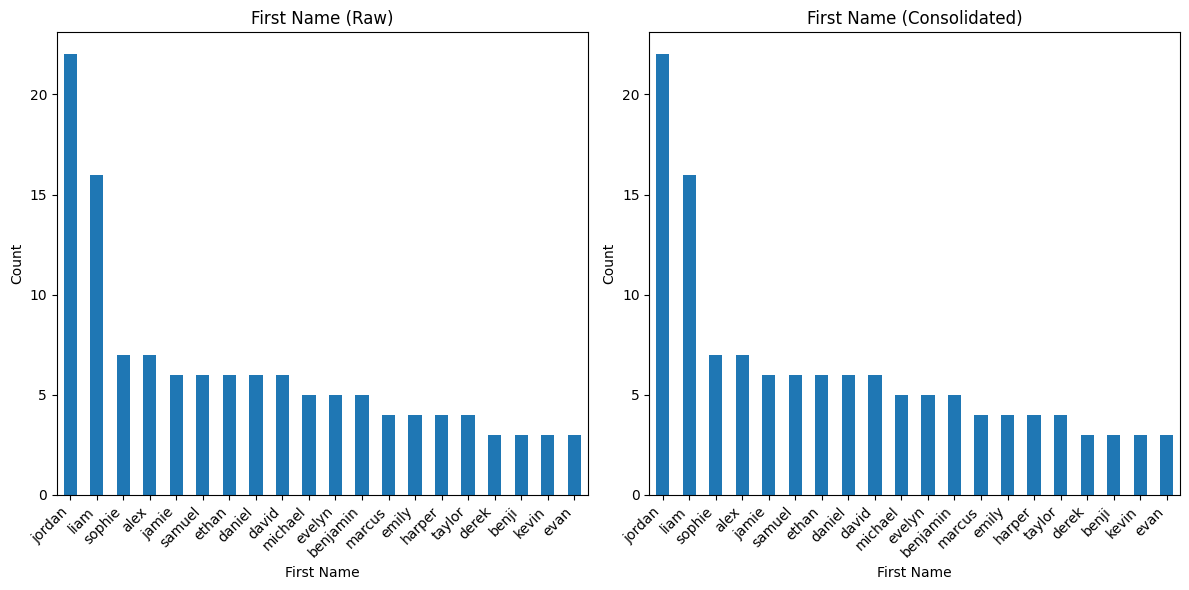

Analyzing and visualizing Last Name...

Last Name (Raw) Diversity Summary:
Unique values: 96
Missing values: 0
Top values:
  grant: 11
  nguyen: 9
  morgan: 8
  kim: 8
  chen: 8

Last Name (Consolidated) Diversity Summary:
Unique values: 96
Missing values: 0
Top values:
  grant: 11
  nguyen: 9
  morgan: 8
  kim: 8
  chen: 8
Saved plot for Last Name at output_distributions/last_name_distribution.png


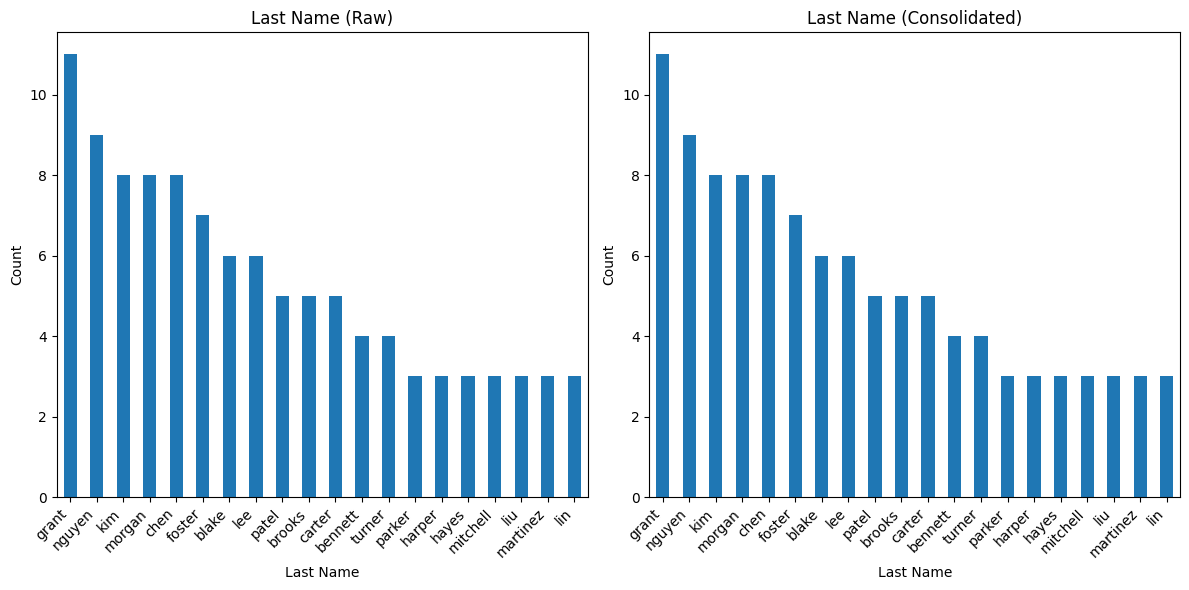

Analyzing and visualizing Email...

Email (Raw) Diversity Summary:
Unique values: 200
Missing values: 0
Top values:
  lily.sanchez@greenwave.org: 1
  samuel.rivera@healtechgroup.com: 1
  evelyn.torres@medisync.co: 1
  avery.morgan@innovaresearch.co: 1
  sophie.grant@celestialnonprofit.org: 1

Email (Consolidated) Diversity Summary:
Unique values: 200
Missing values: 0
Top values:
  lily.sanchez@greenwave.org: 1
  samuel.rivera@healtechgroup.com: 1
  evelyn.torres@medisync.co: 1
  avery.morgan@innovaresearch.co: 1
  sophie.grant@celestialnonprofit.org: 1
Saved plot for Email at output_distributions/email_distribution.png


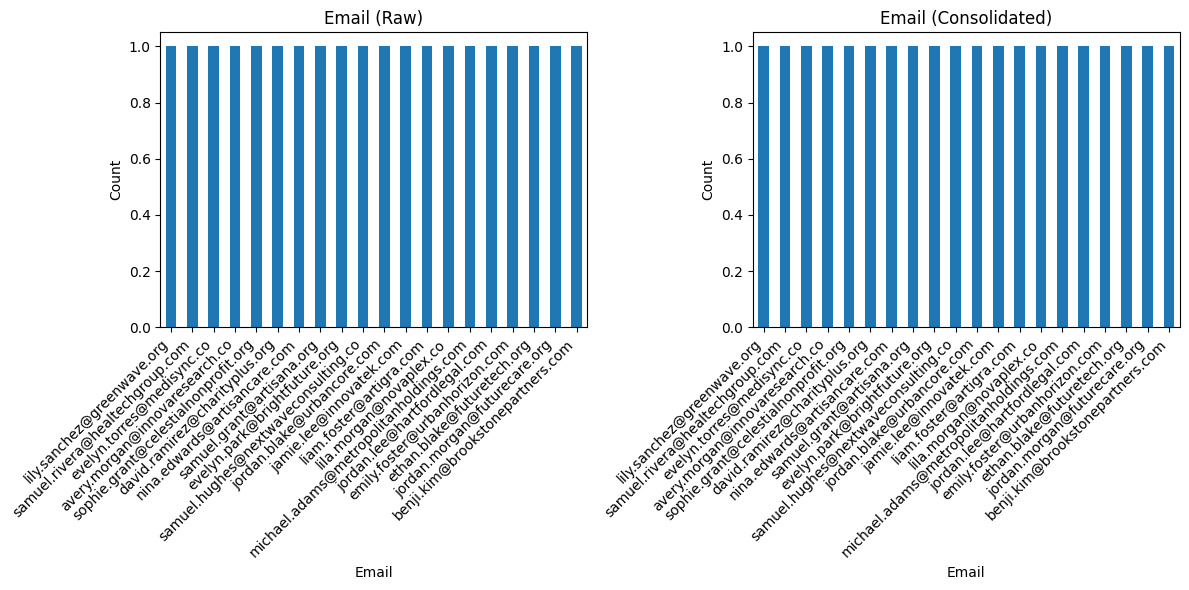

Analyzing and visualizing Phone...

Phone (Raw) Diversity Summary:
Unique values: 2
Missing values: 199
Top values:
  : 199
  (212) 555-6790: 1

Phone (Consolidated) Diversity Summary:
Unique values: 2
Missing values: 0
Top values:
  unknown: 199
  (212) 555-6790: 1
Saved plot for Phone at output_distributions/phone_distribution.png


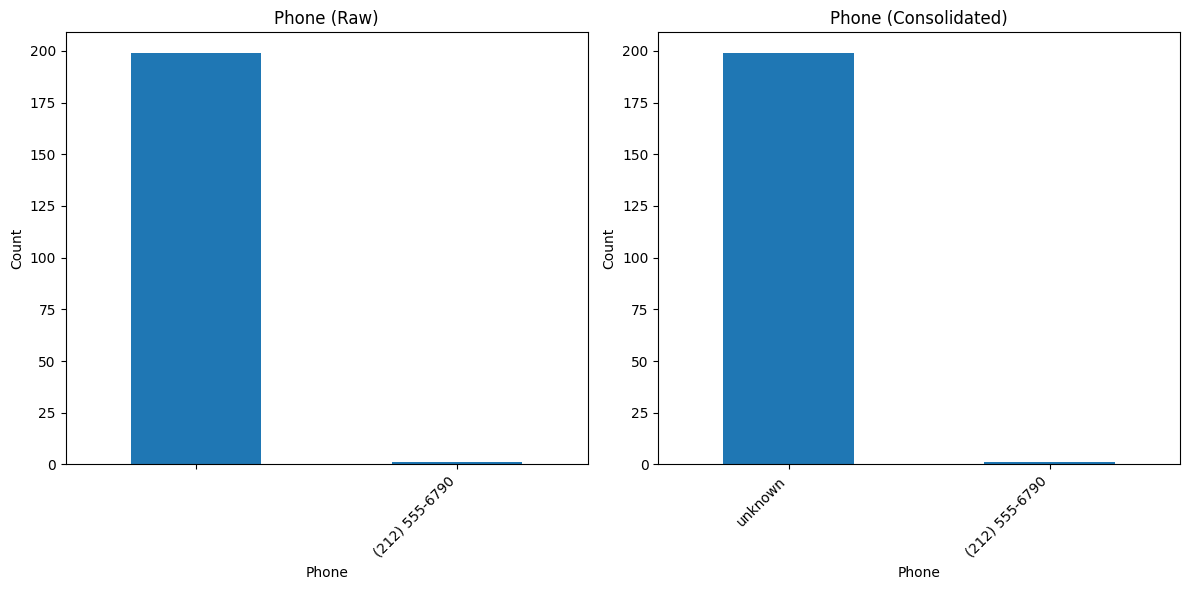

Analyzing and visualizing Company Name...

Company Name (Raw) Diversity Summary:
Unique values: 199
Missing values: 0
Top values:
  greenstream health: 2
  greenwave: 1
  healtech group: 1
  medisync: 1
  innovare research: 1

Company Name (Consolidated) Diversity Summary:
Unique values: 199
Missing values: 0
Top values:
  greenstream health: 2
  greenwave: 1
  healtech group: 1
  medisync: 1
  innovare research: 1
Saved plot for Company Name at output_distributions/company_name_distribution.png


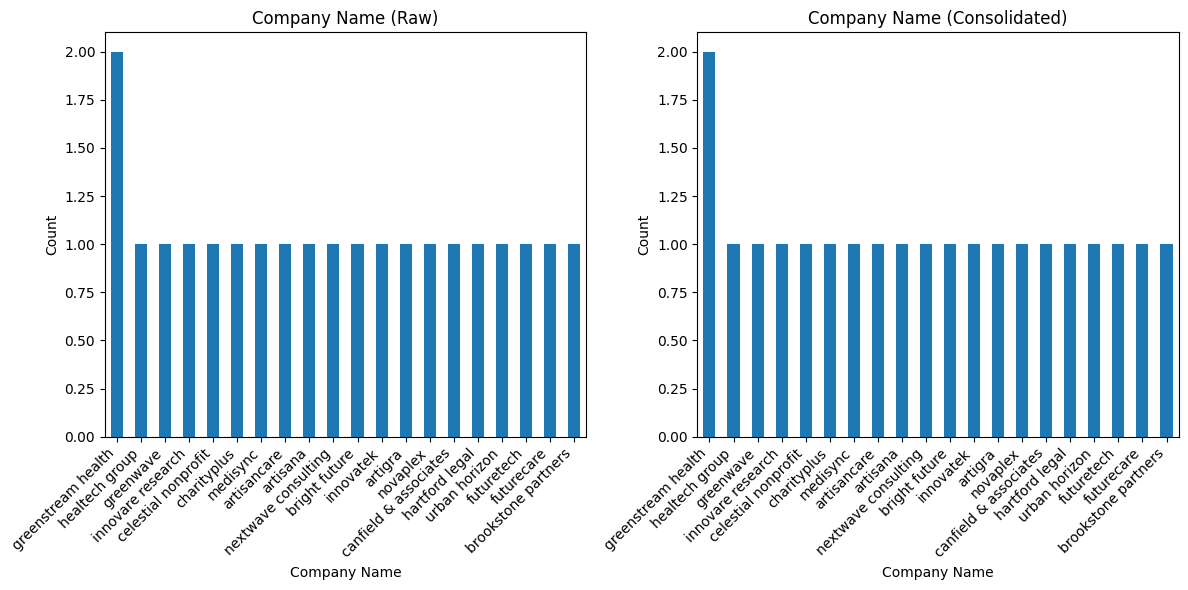

Analyzing and visualizing Industry...

Industry (Raw) Diversity Summary:
Unique values: 13
Missing values: 0
Top values:
  healthcare: 73
  nonprofit: 52
  legal: 29
  creative: 14
  tech: 9

Industry (Consolidated) Diversity Summary:
Unique values: 6
Missing values: 0
Top values:
  healthcare: 74
  nonprofit: 53
  creative: 33
  legal: 29
  tech: 9
Saved plot for Industry at output_distributions/industry_distribution.png


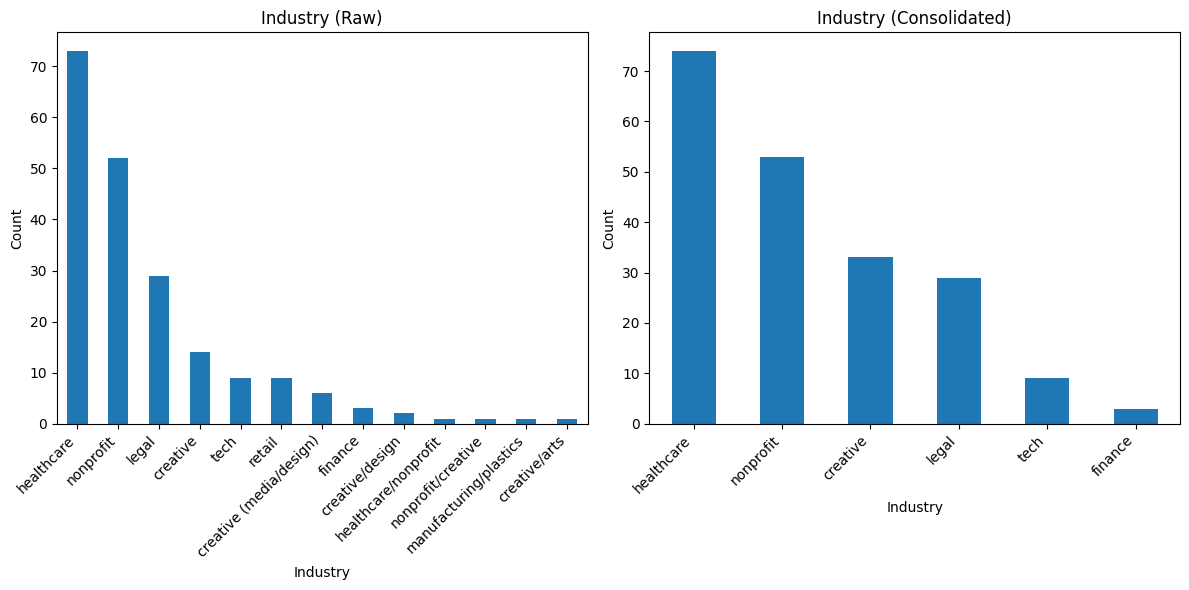

Analyzing and visualizing Company Size...

Company Size (Raw) Diversity Summary:
Unique values: 8
Missing values: 0
Top values:
  small (20–75 employees): 78
  small (20-75 employees): 59
  medium (75-250 employees): 29
  large (250-1,000 employees): 18
  large (250–1,000 employees): 7

Company Size (Consolidated) Diversity Summary:
Unique values: 4
Missing values: 0
Top values:
  small (20-75 employees): 137
  medium (75-250 employees): 29
  large (250-1000 employees): 29
  micro (5-20 employees): 5
Saved plot for Company Size at output_distributions/company_size_distribution.png


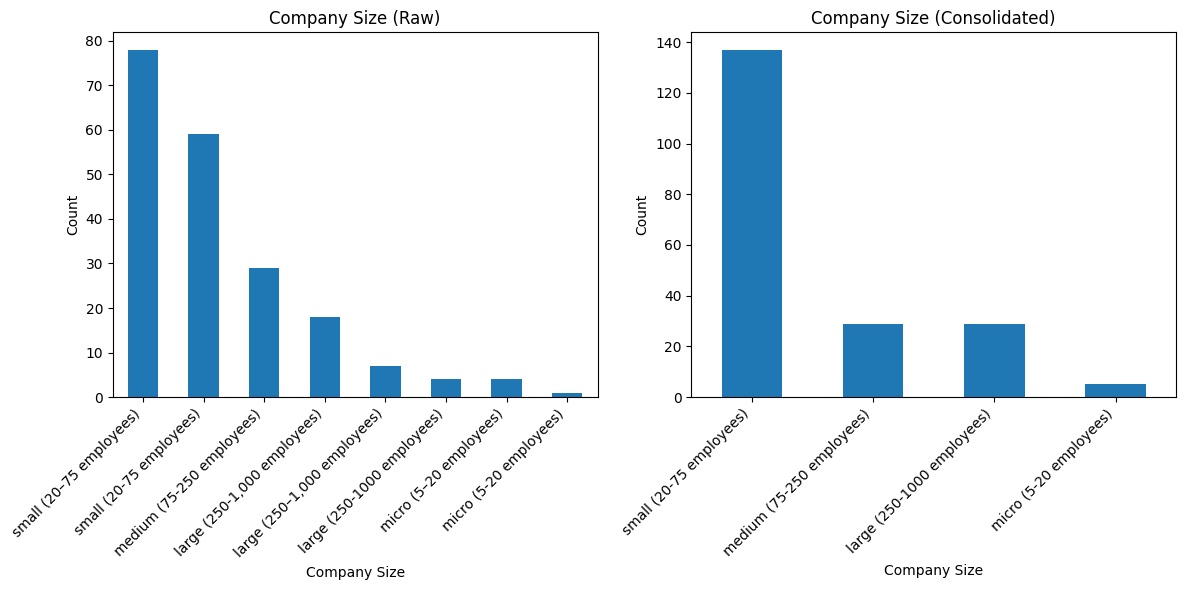

Analyzing and visualizing Growth Stage...

Growth Stage (Raw) Diversity Summary:
Unique values: 11
Missing values: 0
Top values:
  scaling: 60
  mature: 52
  expansion: 30
  pre-seed: 27
  startup: 19

Growth Stage (Consolidated) Diversity Summary:
Unique values: 3
Missing values: 0
Top values:
  scaling: 98
  mature: 55
  early-stage: 47
Saved plot for Growth Stage at output_distributions/growth_stage_distribution.png


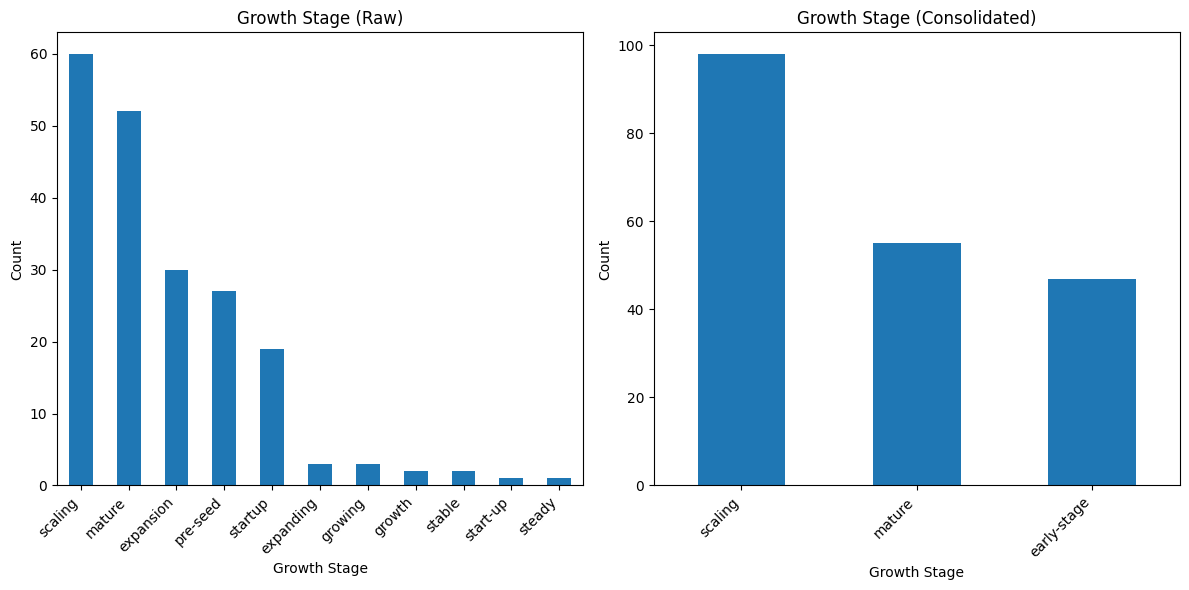

Analyzing and visualizing Current Neighborhood...

Current Neighborhood (Raw) Diversity Summary:
Unique values: 15
Missing values: 0
Top values:
  financial district: 58
  midtown east: 56
  east village: 32
  chelsea: 25
  tribeca: 13

Current Neighborhood (Consolidated) Diversity Summary:
Unique values: 3
Missing values: 0
Top values:
  downtown: 109
  midtown east: 58
  midtown west: 33
Saved plot for Current Neighborhood at output_distributions/current_neighborhood_distribution.png


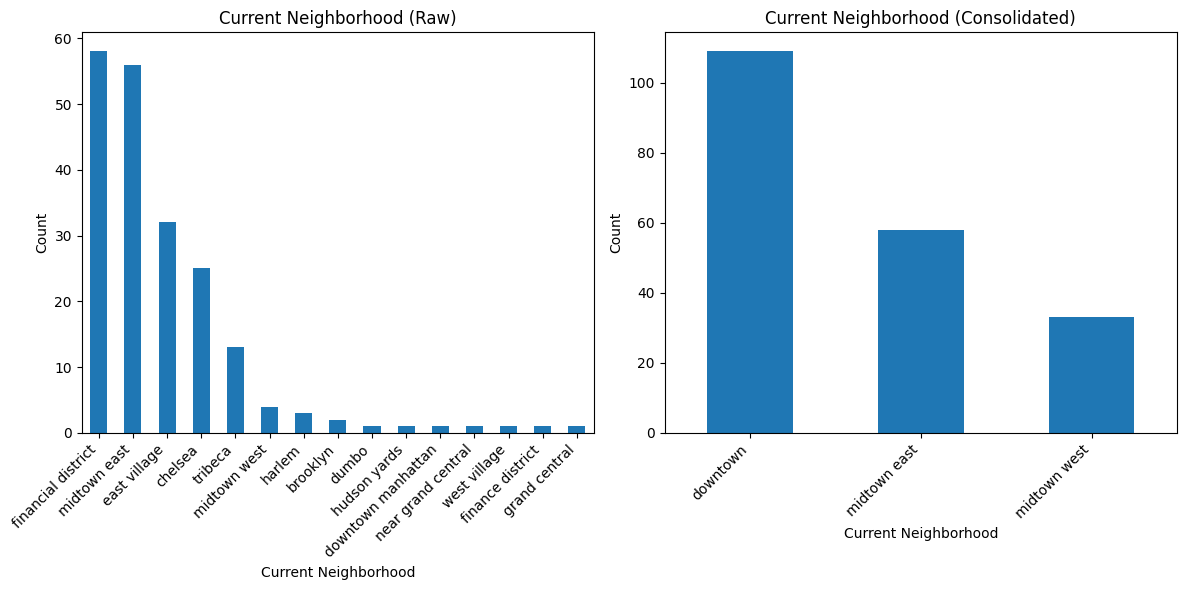

Analyzing and visualizing First Interaction...

First Interaction (Raw) Diversity Summary:
Unique values: 25
Missing values: 0
Top values:
  05-11-2025: 49
  15-11-2025: 42
  12-11-2025: 21
  02-11-2025: 17
  04-11-2025: 13

First Interaction (Consolidated) Diversity Summary:
Unique values: 25
Missing values: 0
Top values:
  05-11-2025: 49
  15-11-2025: 42
  12-11-2025: 21
  02-11-2025: 17
  04-11-2025: 13
Saved plot for First Interaction at output_distributions/first_interaction_distribution.png


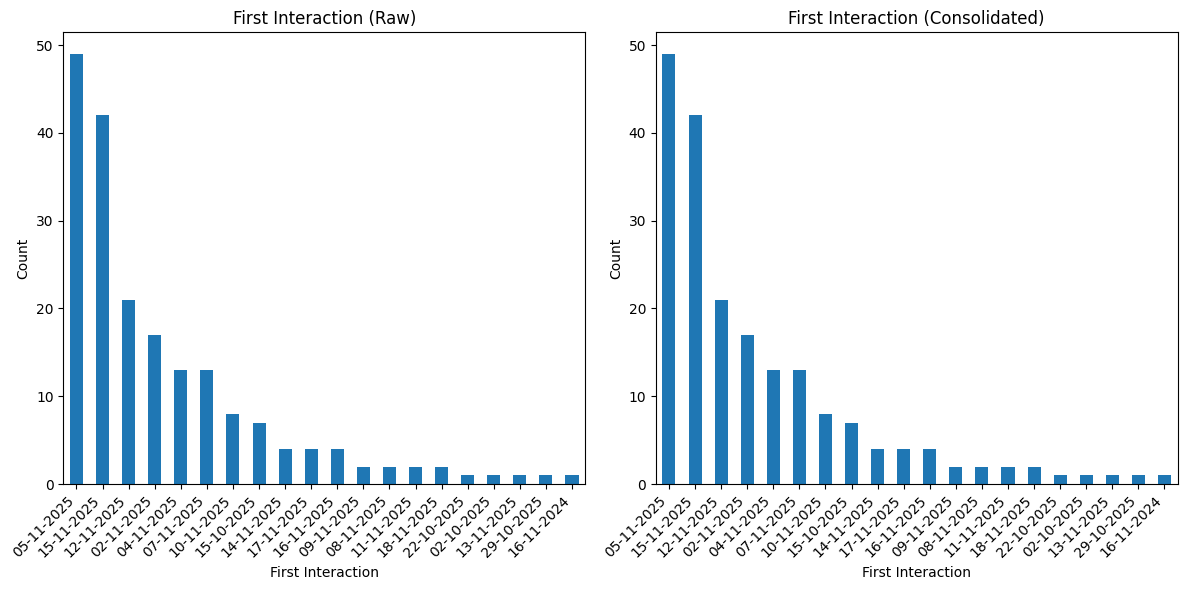

Analyzing and visualizing Last Interaction...

Last Interaction (Raw) Diversity Summary:
Unique values: 38
Missing values: 0
Top values:
  11-11-2025: 19
  10-11-2025: 17
  22-11-2025: 15
  19-11-2025: 14
  09-11-2025: 12

Last Interaction (Consolidated) Diversity Summary:
Unique values: 38
Missing values: 0
Top values:
  11-11-2025: 19
  10-11-2025: 17
  22-11-2025: 15
  19-11-2025: 14
  09-11-2025: 12
Saved plot for Last Interaction at output_distributions/last_interaction_distribution.png


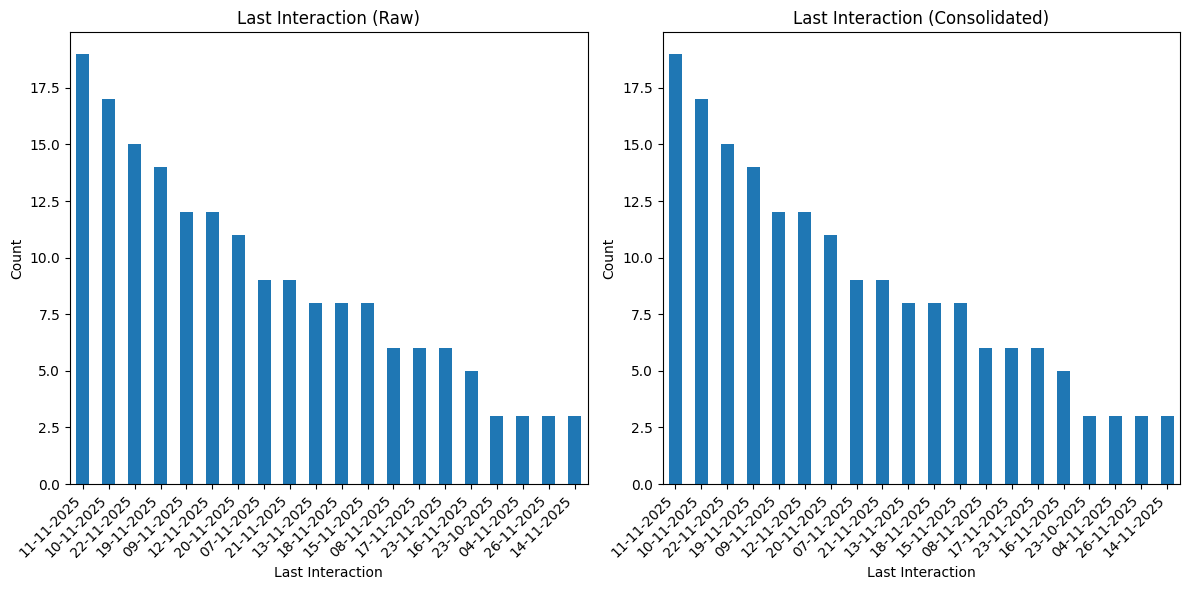

Analyzing and visualizing Decision-Maker Role...

Decision-Maker Role (Raw) Diversity Summary:
Unique values: 35
Missing values: 57
Top values:
  : 57
  executive director: 23
  ceo: 17
  partner: 13
  facilities director: 13

Decision-Maker Role (Consolidated) Diversity Summary:
Unique values: 7
Missing values: 0
Top values:
  unknown: 57
  executive: 41
  facilities: 28
  partner: 24
  operations: 20
Saved plot for Decision-Maker Role at output_distributions/decision-maker_role_distribution.png


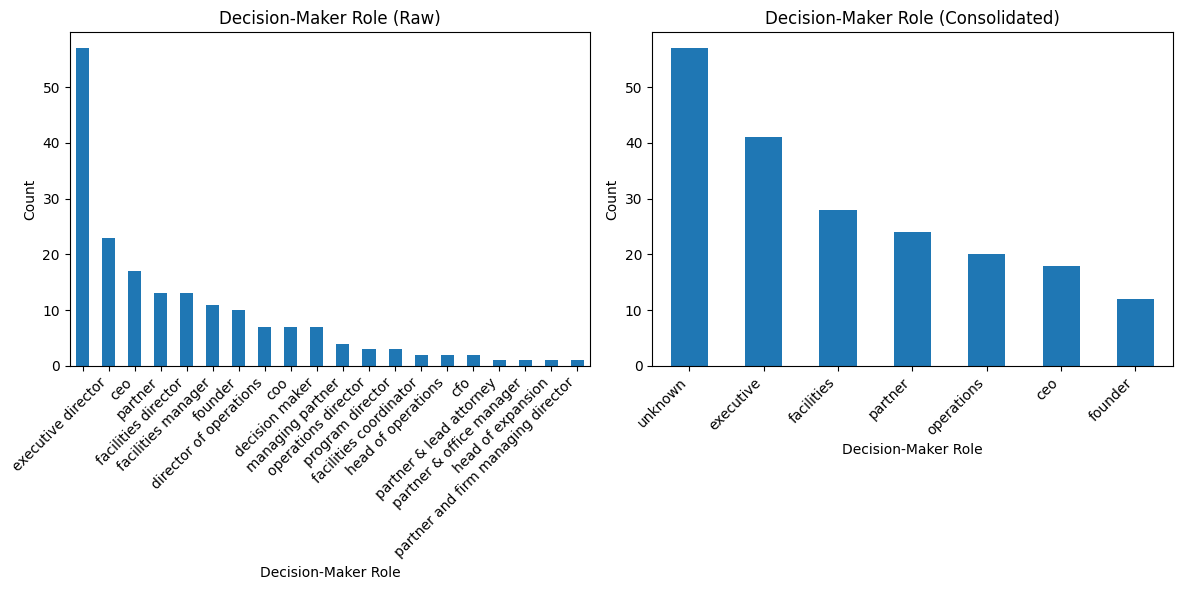

Analyzing and visualizing Moving Timeline...

Moving Timeline (Raw) Diversity Summary:
Unique values: 56
Missing values: 0
Top values:
  short-term (3–6 months): 48
  short-term: 18
  short-term (3 months): 15
  short-term (4-6 months): 15
  short-term (within 3 months): 12

Moving Timeline (Consolidated) Diversity Summary:
Unique values: 4
Missing values: 0
Top values:
  prompt (2–6 months): 153
  swift (0–2 months): 27
  steady (6–12 months): 13
  horizon (12+ months): 7
Saved plot for Moving Timeline at output_distributions/moving_timeline_distribution.png


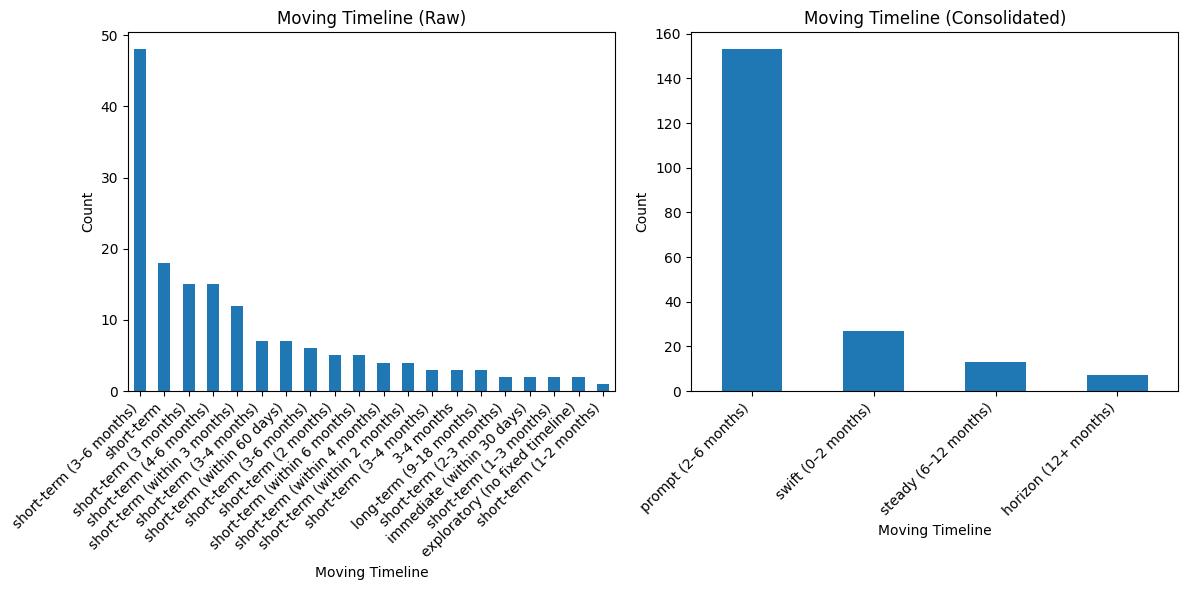

Analyzing and visualizing Pain Points...

Pain Points (Raw) Diversity Summary:
Unique values: 271
Missing values: 0
Top values:
  current space too small: 19
  current space too cramped: 14
  current lease ending soon: 11
  limited parking options: 10
  budget constraints: 10

Pain Points (Consolidated) Diversity Summary:
Unique values: 271
Missing values: 0
Top values:
  current space too small: 19
  current space too cramped: 14
  current lease ending soon: 11
  limited parking options: 10
  budget constraints: 10
Saved plot for Pain Points at output_distributions/pain_points_distribution.png


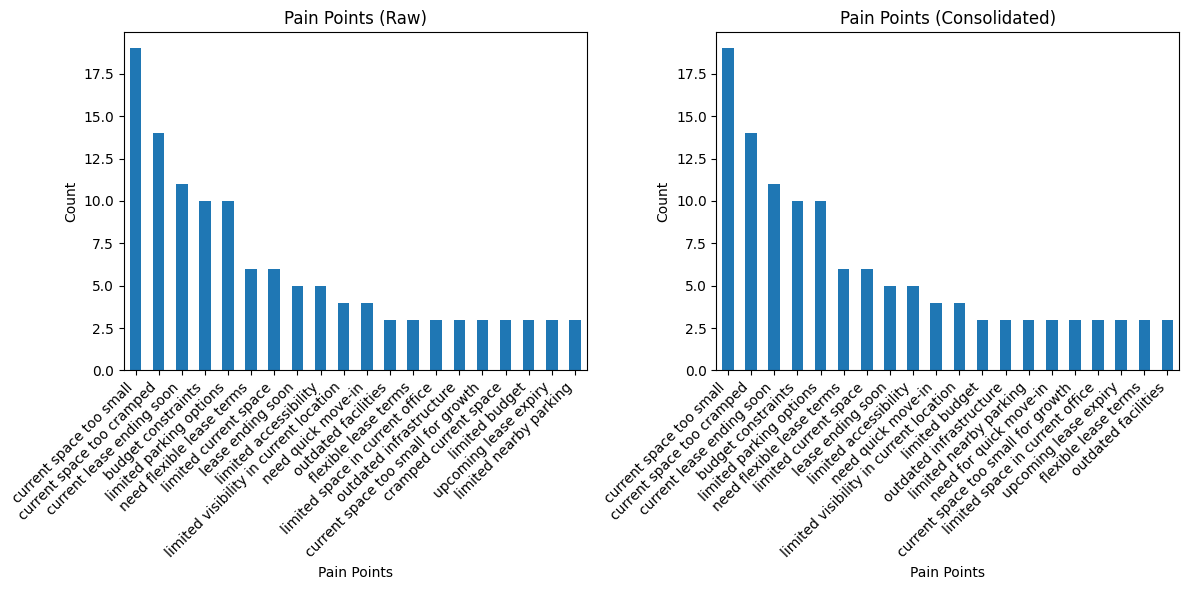

Analyzing and visualizing Urgency Score...

Urgency Score (Raw) Diversity Summary:
Unique values: 5
Missing values: 0
Top values:
  7: 97
  8: 83
  6: 15
  4: 4
  5: 1

Urgency Score (Consolidated) Diversity Summary:
Unique values: 5
Missing values: 0
Top values:
  7: 97
  8: 83
  6: 15
  4: 4
  5: 1
Saved plot for Urgency Score at output_distributions/urgency_score_distribution.png


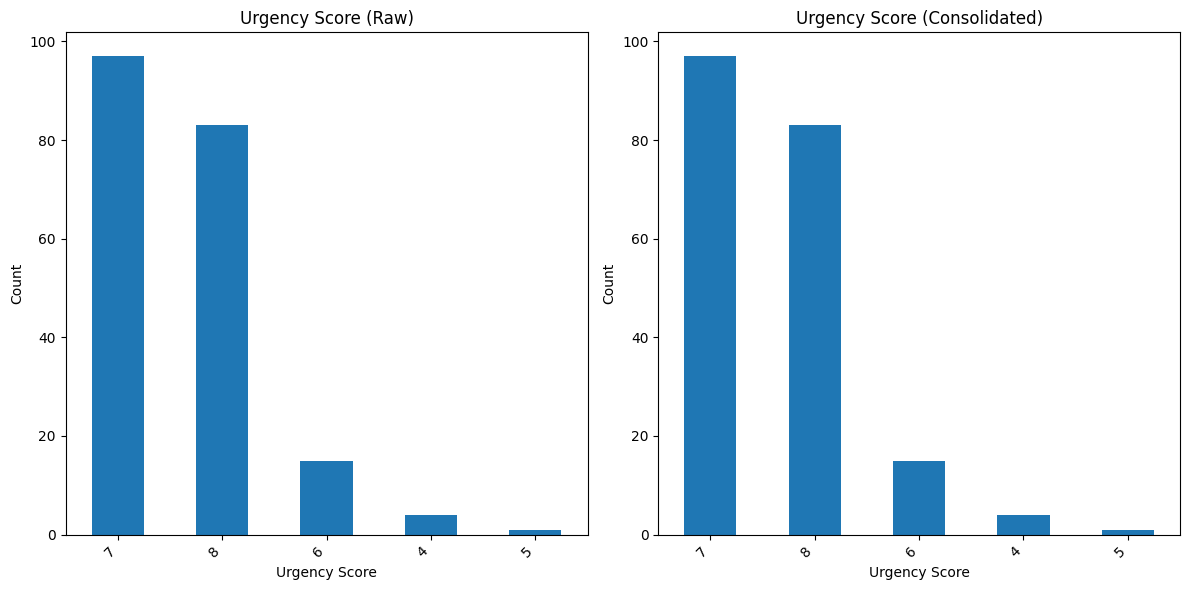

Analyzing and visualizing Outcome...

Outcome (Raw) Diversity Summary:
Unique values: 85
Missing values: 0
Top values:
  tour scheduled: 102
  negotiation ongoing: 6
  ongoing negotiations: 4
  negotiations ongoing: 3
  scheduled tour: 3

Outcome (Consolidated) Diversity Summary:
Unique values: 6
Missing values: 0
Top values:
  tour scheduled: 151
  negotiations ongoing: 31
  pending approval: 10
  lease pending: 3
  interested: 3
Saved plot for Outcome at output_distributions/outcome_distribution.png


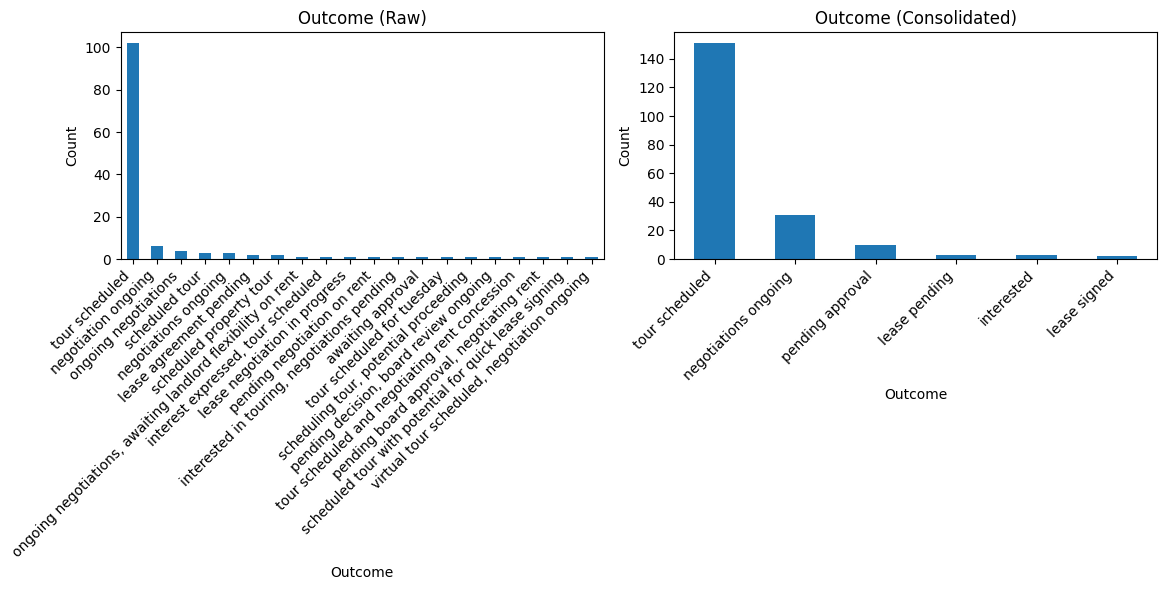

Analyzing and visualizing Tenant Personality...

Tenant Personality (Raw) Diversity Summary:
Unique values: 5
Missing values: 0
Top values:
  decisive: 108
  hesitant: 83
  enthusiastic: 7
  detail-obsessed: 1
  skeptical: 1

Tenant Personality (Consolidated) Diversity Summary:
Unique values: 3
Missing values: 0
Top values:
  decisive: 108
  hesitant: 85
  enthusiastic: 7
Saved plot for Tenant Personality at output_distributions/tenant_personality_distribution.png


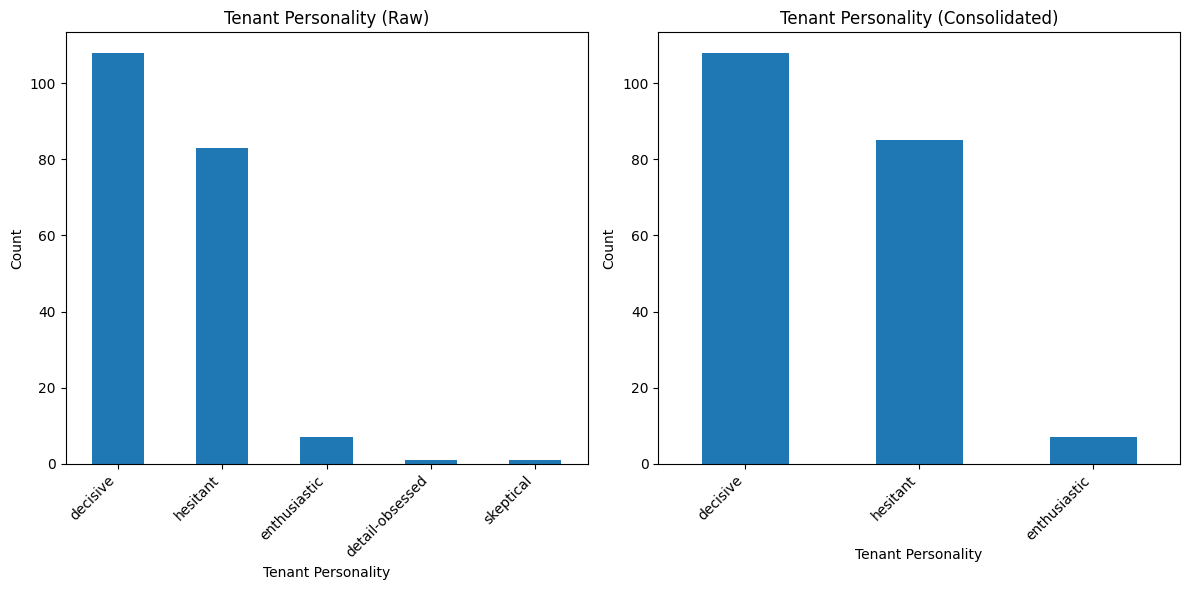

Analyzing and visualizing Property Type...

Property Type (Raw) Diversity Summary:
Unique values: 21
Missing values: 0
Top values:
  office: 156
  retail: 19
  flex-space: 4
  flex-space (mixed-use adaptability): 3
  medical office: 2

Property Type (Consolidated) Diversity Summary:
Unique values: 5
Missing values: 0
Top values:
  office: 161
  retail: 20
  flex-space: 10
  medical: 8
  event venue: 1
Saved plot for Property Type at output_distributions/property_type_distribution.png


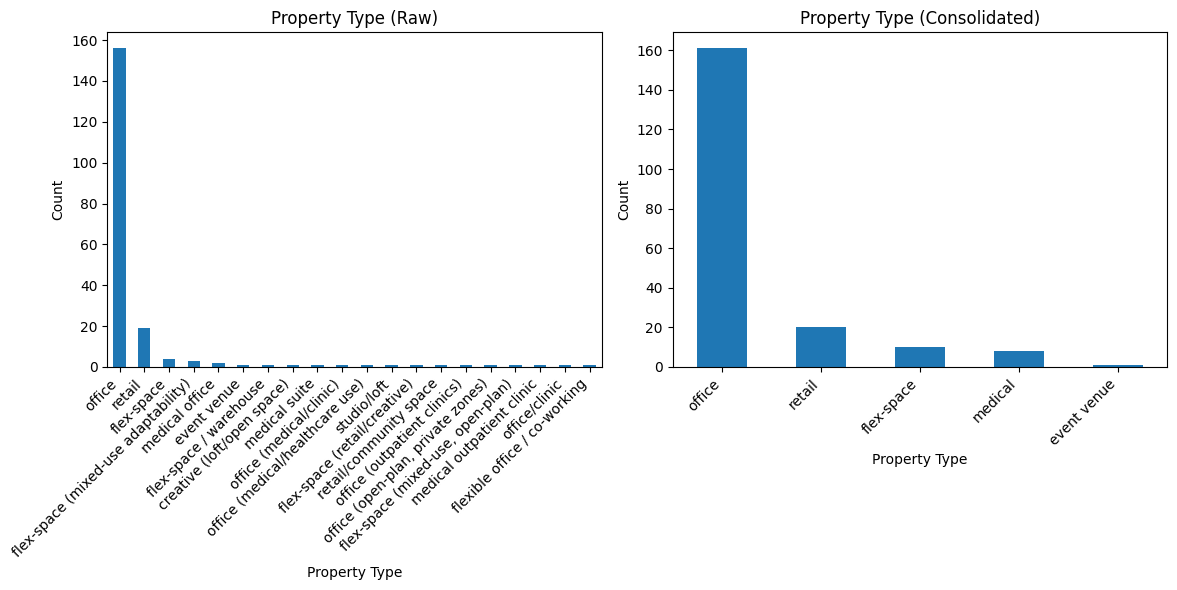

Analyzing and visualizing Preferred Neighborhood...

Preferred Neighborhood (Raw) Diversity Summary:
Unique values: 22
Missing values: 0
Top values:
  chelsea: 88
  midtown east: 70
  tribeca: 31
  grand central: 8
  hudson yards: 7

Preferred Neighborhood (Consolidated) Diversity Summary:
Unique values: 3
Missing values: 0
Top values:
  midtown west: 96
  midtown east: 78
  downtown: 45
Saved plot for Preferred Neighborhood at output_distributions/preferred_neighborhood_distribution.png


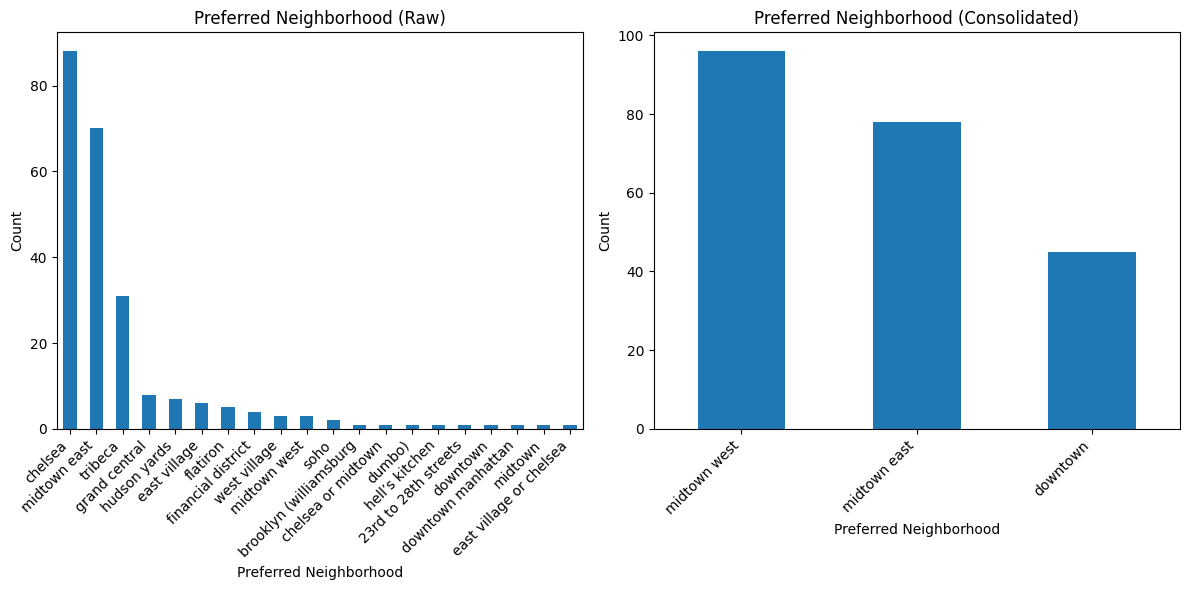

Analyzing and visualizing Estimated or Stated Budget...

Estimated or Stated Budget (Raw) Diversity Summary:
Unique values: 40
Missing values: 0
Top values:
  $45k/month: 39
  $70k/month: 31
  $40k/month: 26
  $60k/month: 25
  $35k/month: 14

Estimated or Stated Budget (Consolidated) Diversity Summary:
Unique values: 10
Missing values: 0
Top values:
  $40k-$50k: 84
  $60k-$70k: 38
  $70k+: 37
  $30k-$40k: 30
  $0k-$30k: 4
Saved plot for Estimated or Stated Budget at output_distributions/estimated_or_stated_budget_distribution.png


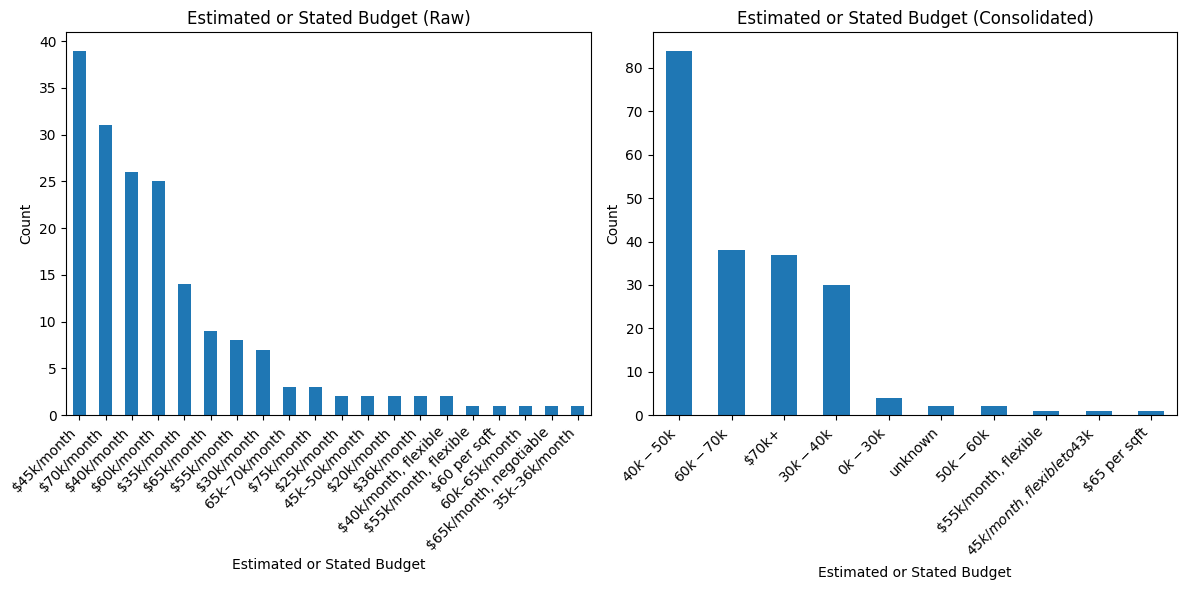

Analyzing and visualizing Must-Haves...

Must-Haves (Raw) Diversity Summary:
Unique values: 213
Missing values: 0
Top values:
  natural light: 48
  ada compliance: 28
  high-speed internet: 14
  high ceilings: 14
  good natural light: 11

Must-Haves (Consolidated) Diversity Summary:
Unique values: 127
Missing values: 0
Top values:
  natural light: 65
  ada compliance: 39
  conference rooms: 28
  accessibility: 27
  public transit access: 23
Saved plot for Must-Haves at output_distributions/must-haves_distribution.png


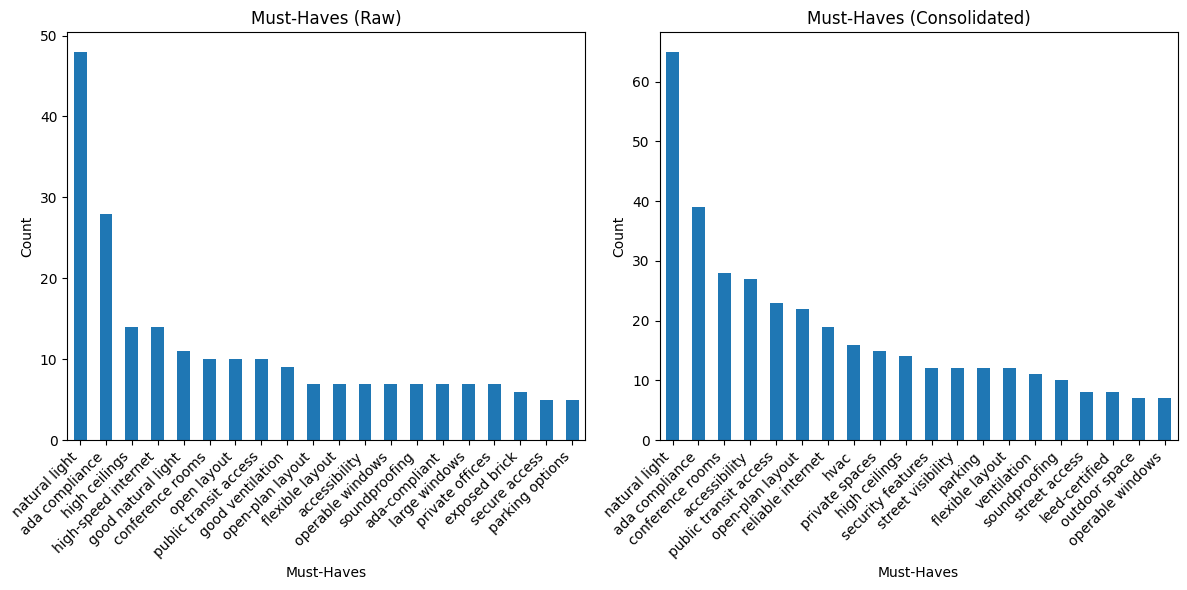

Analyzing and visualizing Nice-to-Haves...

Nice-to-Haves (Raw) Diversity Summary:
Unique values: 109
Missing values: 0
Top values:
  nearby parking: 6
  natural light: 6
  onsite parking: 5
  parking nearby: 5
  outdoor terrace: 5

Nice-to-Haves (Consolidated) Diversity Summary:
Unique values: 58
Missing values: 0
Top values:
  parking: 20
  outdoor space: 12
  building amenities: 11
  natural light: 10
  signage: 8
Saved plot for Nice-to-Haves at output_distributions/nice-to-haves_distribution.png


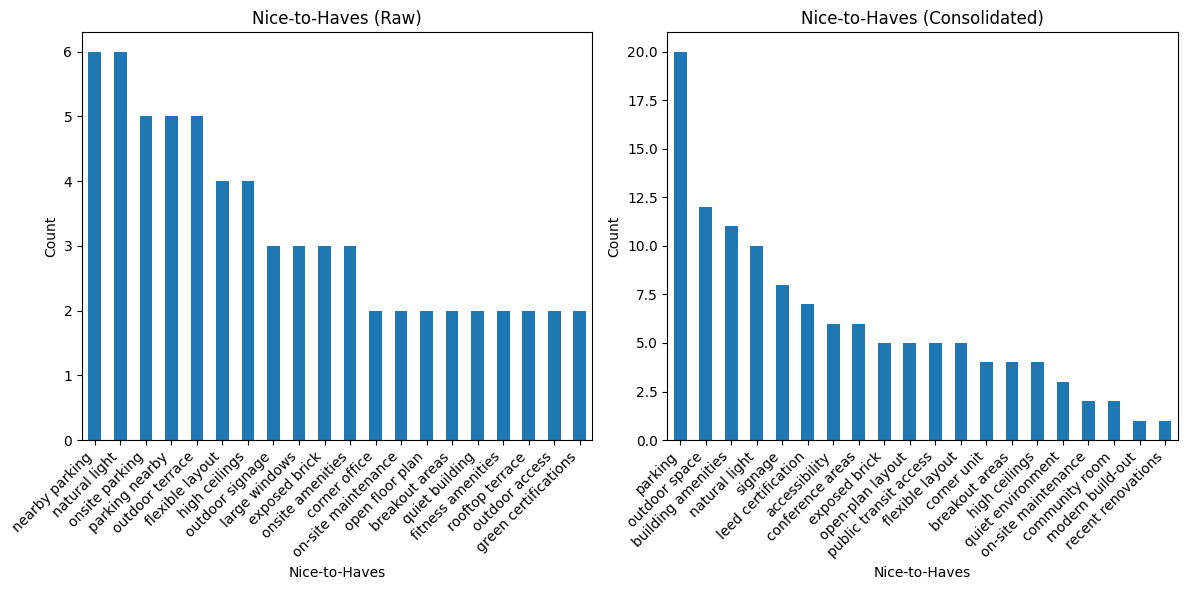

Analyzing and visualizing Space Size...

Space Size (Raw) Diversity Summary:
Unique values: 52
Missing values: 0
Top values:
  4,000 sqft: 44
  4,200 sqft: 19
  4,500 sqft: 18
  8,000 sqft: 16
  3,200 sqft: 9

Space Size (Consolidated) Diversity Summary:
Unique values: 19
Missing values: 0
Top values:
  5000-7499 sf: 88
  2500-4999 sf: 34
  7500-9999 sf: 29
  10000+ sf: 19
  1000-2499 sf: 10
Saved plot for Space Size at output_distributions/space_size_distribution.png


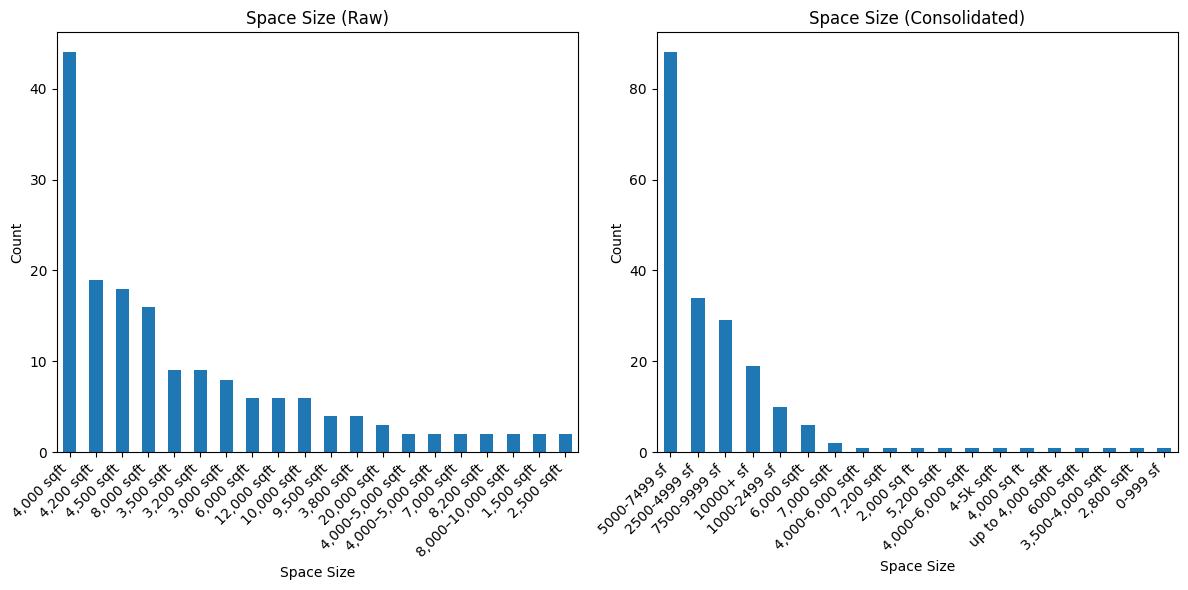

Analyzing and visualizing Preferred Lease Term...

Preferred Lease Term (Raw) Diversity Summary:
Unique values: 38
Missing values: 76
Top values:
  : 76
  3 years: 28
  5 years: 22
  3-5 years: 19
  3–5 years: 7

Preferred Lease Term (Consolidated) Diversity Summary:
Unique values: 9
Missing values: 76
Top values:
  : 76
  3 year: 62
  5 year: 29
  2 year: 8
  <1 year: 7
Saved plot for Preferred Lease Term at output_distributions/preferred_lease_term_distribution.png


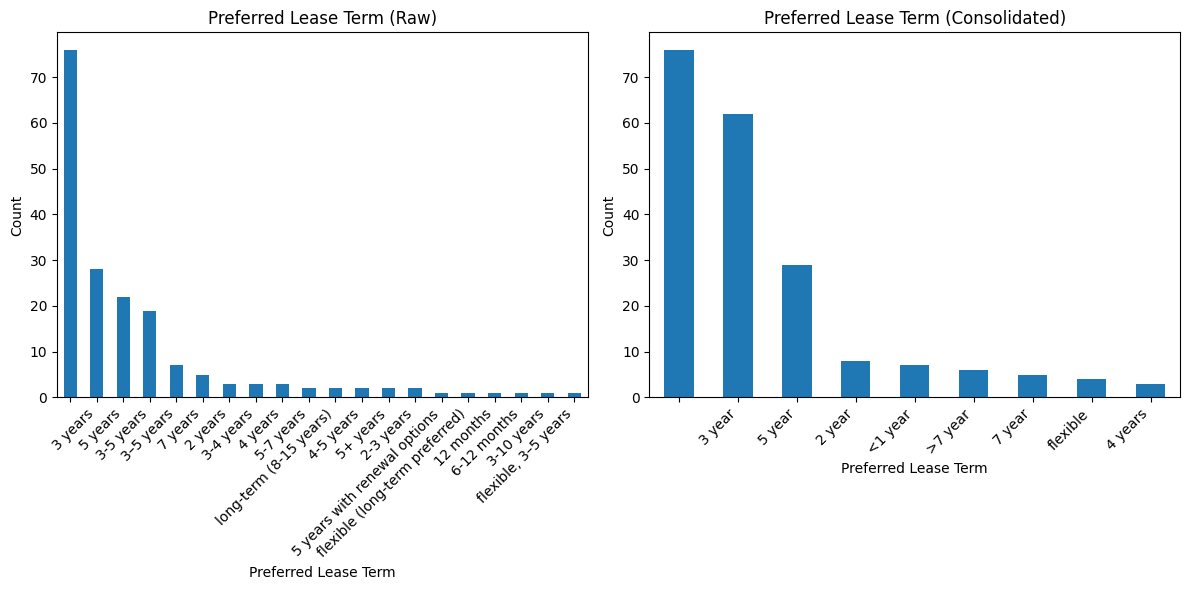

In [ ]:
with open("synthetic_email_data.json", "r") as f:
    data = json.load(f)
analyze_and_visualize(data, "output_distributions")

In [ ]:
def consolidate_record(record, features, consolidation_maps):
       """Applies consolidation maps to a single record."""
       record = copy.deepcopy(record)  # Create a deep copy to avoid modifying the original data
       for feature, config in features.items():
           nested_path = config["nested_path"]
           multi_label = config.get("multi_label", False)
           consolidation_map = consolidation_maps.get(feature, {})

           # Extract the raw value
           raw_value = extract_feature(record, nested_path, multi_label)

           # Apply consolidation
           consolidated_value = apply_consolidation([raw_value], consolidation_map, multi_label)

           # Update the record with the consolidated value
           current_level = record
           for i, key in enumerate(nested_path):
               if i == len(nested_path) - 1:
                   current_level[key] = consolidated_value[0]  # Assign the consolidated value
               else:
                   current_level = current_level[key]
       return record

In [ ]:
# Load your data
with open("synthetic_email_data.json", "r") as f:
    data = json.load(f)

# Process each record
consolidated_data = [consolidate_record(record, FEATURES, CONSOLIDATION_MAPS) for record in data]

# Save the consolidated data to a new file
output_file = os.path.join(OUTPUT_DIR, "consolidated_data.json")
with open(output_file, "w") as f:
    json.dump(consolidated_data, f, indent=4)

print(f"Consolidated data saved to: {output_file}")

Consolidated data saved to: ./dataset_analysis/consolidated_data.json
